# PDFs and CDFs

This notebook demonstrates how to move between a probability density function `PDF` and cumulative density function `CDF`. If one has a PDF, a CDF may be derived from integrating over the PDF; if one has a CDF, the PDF may be derived from taking the derivative over the CDF.

## Standard normal distribution

Here, we visualize the PDF and CDF for the standard normal distribution. The functions `scipy.stats.norm.pdf` and `scipy.stats.norm.cdf` will be used to generate the curves and data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import warnings

plt.style.use('ggplot')
np.random.seed(37)
warnings.filterwarnings('ignore')

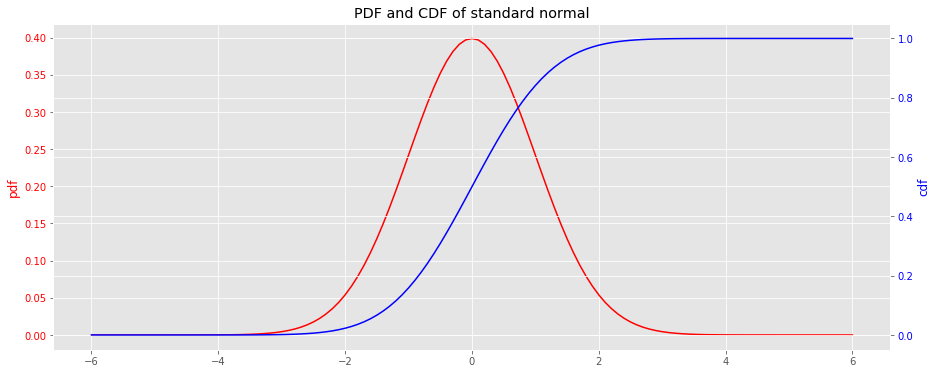

In [2]:
x = np.arange(-6, 6.1, 0.1)
y_pdf = norm.pdf(x)
y_cdf = norm.cdf(x)

fig, ax = plt.subplots(figsize=(15, 6))

ax = [ax, ax.twinx()]

_ = ax[0].plot(x, y_pdf, label='pdf', color='r')
_ = ax[1].plot(x, y_cdf, label='cdf', color='b')

_ = ax[0].tick_params(axis='y', labelcolor='r')
_ = ax[1].tick_params(axis='y', labelcolor='b')

_ = ax[0].set_ylabel('pdf', color='r')
_ = ax[1].set_ylabel('cdf', color='b')

_ = ax[0].set_title('PDF and CDF of standard normal')

We will use `scipy.misc.derivative` and `scipy.integrate.quad` to take the derivative of the CDF to get the PDF and to integrate the PDF to get the CDF, respectively.

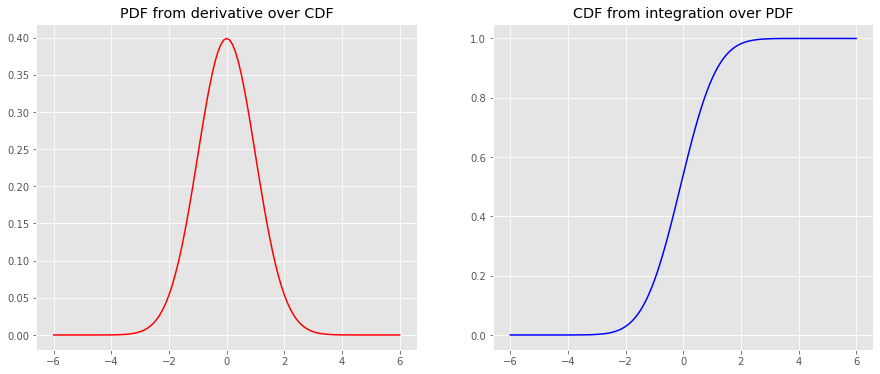

In [3]:
from scipy.misc import derivative
from scipy.integrate import quad

y_cdf = np.array([tup[0] for tup in [quad(norm.pdf, a, b) for a, b in [(a, b) for a, b in zip(x, x[1:len(x)])]]] + [0]).cumsum()
y_pdf = derivative(norm.cdf, x, dx=1e-6)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

_ = ax[0].plot(x, y_pdf, color='r')
_ = ax[1].plot(x, y_cdf, color='b')

_ = ax[0].set_title('PDF from derivative over CDF')
_ = ax[1].set_title('CDF from integration over PDF')

## Log-normal distribution

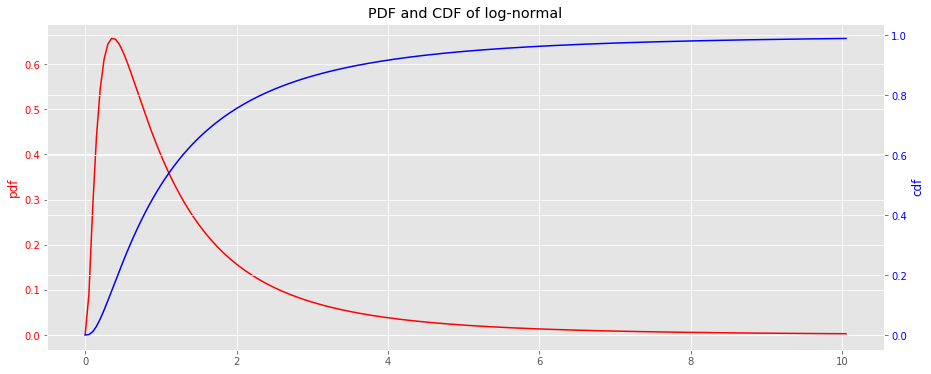

In [4]:
from scipy.stats import lognorm

lognorm_pdf = lambda x: lognorm.pdf(x, 1)
lognorm_cdf = lambda x: lognorm.cdf(x, 1)

x = np.arange(0, 10.1, 0.05)
y_pdf = lognorm_pdf(x)
y_cdf = lognorm_cdf(x)

fig, ax = plt.subplots(figsize=(15, 6))

ax = [ax, ax.twinx()]

_ = ax[0].plot(x, y_pdf, label='pdf', color='r')
_ = ax[1].plot(x, y_cdf, label='cdf', color='b')

_ = ax[0].tick_params(axis='y', labelcolor='r')
_ = ax[1].tick_params(axis='y', labelcolor='b')

_ = ax[0].set_ylabel('pdf', color='r')
_ = ax[1].set_ylabel('cdf', color='b')

_ = ax[0].set_title('PDF and CDF of log-normal')

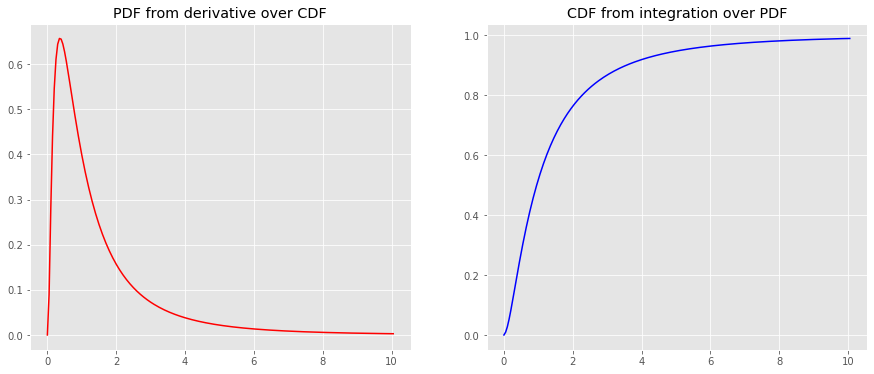

In [5]:
y_cdf = np.array([tup[0] for tup in [quad(lognorm_pdf, a, b) for a, b in [(a, b) for a, b in zip(x, x[1:len(x)])]]] + [0]).cumsum()
y_pdf = derivative(lognorm_cdf, x, dx=1e-6)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

_ = ax[0].plot(x, y_pdf, color='r')
_ = ax[1].plot(x, y_cdf, color='b')

_ = ax[0].set_title('PDF from derivative over CDF')
_ = ax[1].set_title('CDF from integration over PDF')

## Learn a PDF from arbitrary CDF

We will generate an arbitrary CDF using the logistic function. 

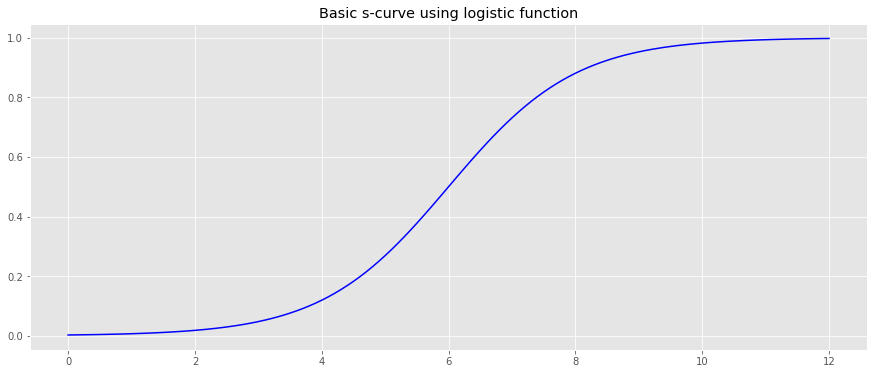

In [6]:
logistic = lambda x, L=1, x_0=0, k=1: L / (1 + np.exp(-k * (x - x_0)))

x = np.arange(-6, 6.1, 0.1)
y = logistic(x)
x = x + 6.0

fig, ax = plt.subplots(figsize=(15, 6))
_ = ax.plot(x, y, color='b')
_ = ax.set_title('Basic s-curve using logistic function')

The parameters, $L$, $x_0$ and $k$, for the logistic function will be learned.

In [7]:
from scipy.optimize import curve_fit

L_estimate = y.max()
x_0_estimate = np.median(x)
k_estimate = 1.0

p_0 = [L_estimate, x_0_estimate, k_estimate]

popt, pcov = curve_fit(logistic, x, y, p_0, method='dogbox')

L, x_0, k = popt[0], popt[1], popt[2]

Assuming the PDF is log-normal, we will take the derivative of the CDF to estimate the PDF.

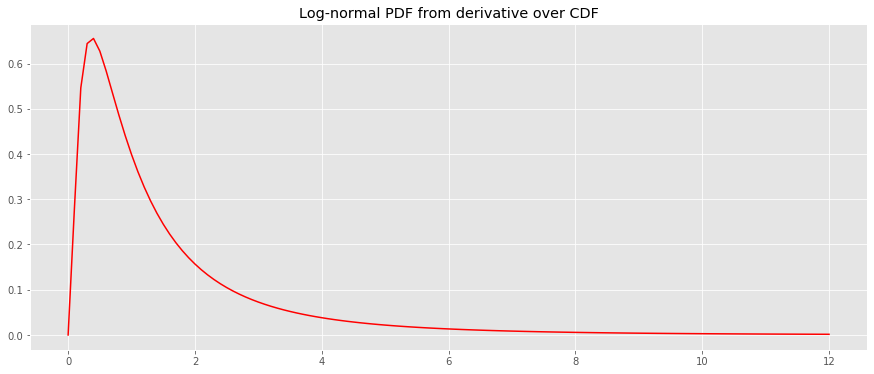

In [8]:
logistic = lambda x, L=L, x_0=x_0, k=k: L / (1 + np.exp(-k * (x - x_0)))

y_pdf = derivative(lognorm_cdf, x, dx=1e-6)

fig, ax = plt.subplots(figsize=(15, 6))

_ = ax.plot(x, y_pdf, color='r')
_ = ax.set_title('Log-normal PDF from derivative over CDF')

## Learn a CDF from arbitrary PDF

We will generate a guassian-mixture (GM) PDF and derive the CDF using integration.

In [9]:
N = 1000
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N))))

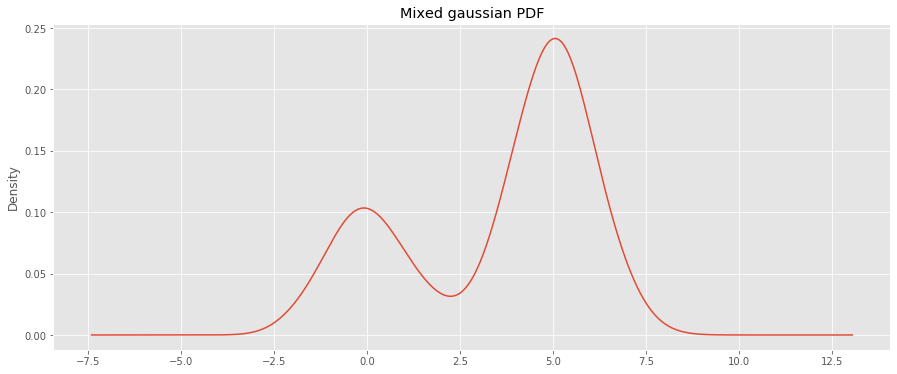

In [10]:
s = pd.Series(X)

fig, ax = plt.subplots(figsize=(15, 6))

_ = s.plot(kind='kde', bw_method='scott', ax=ax)
_ = ax.set_title('Mixed gaussian PDF')

We then use a kernel density estimator to learn the PDF.

In [11]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X[:, np.newaxis])
gmm_pdf = lambda x: np.exp(kde.score(np.array([x]).reshape(-1, 1)))

Finally, the CDF of the PDF will be estimated using integration.

In [12]:
%%time
x = np.arange(-5, 10.1, 0.1)
y_cdf = np.array([tup[0] for tup in [quad(gmm_pdf, a, b) for a, b in [(a, b) for a, b in zip(x, x[1:len(x)])]]] + [0]).cumsum()

CPU times: user 522 ms, sys: 0 ns, total: 522 ms
Wall time: 548 ms


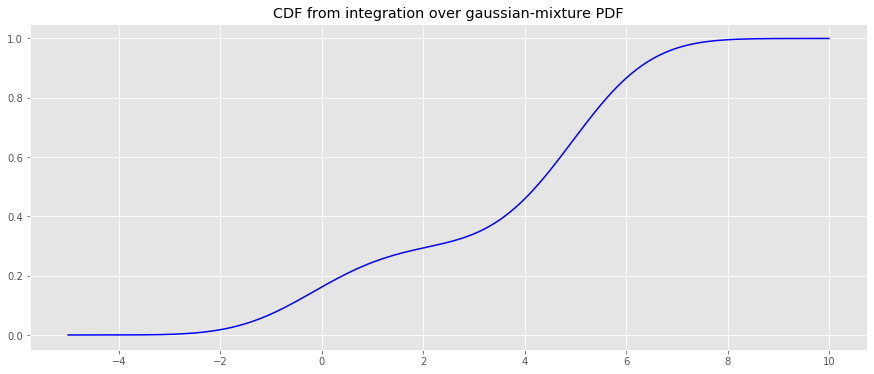

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

_ = ax.plot(x, y_cdf, color='b')
_ = ax.set_title('CDF from integration over gaussian-mixture PDF')